In [3]:
import jax.numpy as jnp
import numpy as np
import jax.random as jrandom
from jax import jit, grad, jacfwd

import sys 
import os 
HOME = os.getenv("HOME")
sys.path.append(HOME + "/curr_adventure/exact_sampling/")
sys.path.append(HOME + "/curr_adventure/exact_sampling/Optimization")

from Optimization import NewtonMethod
from pdfo import newuoa

from NEWUO_test import NEWUOA_Wrapper

# from pow_sampling_set import pow_SG, create_approx_S_multi
# from Functions import PyCutestGetter, load_cutest_quadratic, HeartDisease
# from AdaptiveFD import adapt_FD
# from FD import FD

from tqdm import tqdm

import matplotlib.pyplot as plt

import scipy

%load_ext autoreload
%autoreload 2

In [9]:
def loss_getter(dim, D, sig, coeff=0.1):
    def helper(X):
        S = X.reshape(dim, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ D @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        
        return 1/4 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term) + coeff*jnp.linalg.norm(S, ord="fro")**4
    return helper

def lmbda_loss(lmbdas, D_diag, sig, l_max_idx):
    dim = len(D_diag)

    a = D_diag @ lmbdas / len(lmbdas)
#     print(repr(lmbdas))
    return 1/4. * a**2 * dim / lmbdas[l_max_idx] + sig**2 * dim/lmbdas[l_max_idx] + sig**2 * jnp.sum(1/lmbdas)



In [15]:
def lambda_coeff_zero(D_diag, sig):
    dim = len(D_diag)
    D_diag = jnp.abs(D_diag)
    D_min = jnp.min(D_diag)
    D_sum = jnp.sum(jnp.sqrt(D_diag)) - jnp.sqrt(D_min)
    numerator = 2 * (1 + dim) * D_min * sig**2 + D_sum**2 * sig**2 + jnp.sqrt(D_sum**2 * (8 * (1 + dim) * D_min + D_sum**2) * sig**4)
    
    a = jnp.sqrt(2 * numerator/(dim * D_min))
    l = (2 * (1 + dim) * D_min * sig**2 + numerator)/(D_min**2 * a)

    lmbdas = [(sig * jnp.sqrt(2*l/(D_diag[i] * a))) for i in range(len(D_diag))]
    lmbdas[jnp.argmin(jnp.abs(D_diag))] = l
    
    return jnp.array(lmbdas)

In [65]:
sig = 1 

D_diag1 = np.array([10])
D_diag2 = np.array([10, 200, 1e4, 1e3, 1e4])




In [191]:
l1 = lambda_coeff_zero(D_diag, sig)
print(l1)
lmbda_loss(l1, D_diag, sig, np.argmin(D_diag))

[70.06956454  0.44201352  0.31563015  0.2585657   0.22429736]


DeviceArray(27.68424963, dtype=float64)

In [61]:
l1 = lambda_coeff_zero(D_diag1, sig)
print(l1)
f1 = lmbda_loss(l1, D_diag1, sig, np.argmin(D_diag1))
print("fun1", f1)
l2 = lambda_coeff_zero(D_diag2, sig)
print(l2)
f2 = lmbda_loss(l2, D_diag2, sig, np.argmin(D_diag2))
print("fun2", f2)
print("sum", f1 + f2)




[0.01414214]
fun1 282.842712474619
[1.46831838e+01 6.32749362e-03 2.00092917e-02 6.32749362e-03]
fun2 732.7964531258563
sum 1015.6391656004753


In [66]:
l1 = lambda_coeff_zero(D_diag1, sig)
print(l1)
f1 = lmbda_loss(l1, D_diag1, sig, np.argmin(D_diag1))
print("fun1", f1)
l2 = lambda_coeff_zero(D_diag2, sig)
print(l2)
f2 = lmbda_loss(l2, D_diag2, sig, np.argmin(D_diag2))
print("fun2", f2)
print("sum", f1 + f2)





[0.28284271]
fun1 14.14213562373095
[1.74212821e+01 5.00247545e-02 7.07456862e-03 2.23717503e-02
 7.07456862e-03]
fun2 695.4729766472464
sum 709.6151122709773


In [67]:

def get_S_pow_index_sets(D_diag,):
    """Returns a set of sets. Each set with the indecies of H to use."""
    dim = len(D_diag)
    binary_dim = (bin(dim)[2:])[::-1]
    res = {}
    for i in range(len(binary_dim)):
        if binary_dim[i] == "1":
            res[i] = []
            
    bin_used = sorted(res.keys())
    
    curr_n = len(bin_used) - 1
    upper_n = curr_n + 1
    lower_n = 0

    end_mid = True
    
    start = 0
    if end_mid:
        end = len(D_diag) // 2 + len(D_diag) % 2 
    else:
        end = len(D_diag) - 1
    
    argsorted_D_diag = jnp.argsort(D_diag)
    while end < len(D_diag) and start < end:
        while len(res[bin_used[curr_n]]) == 2**bin_used[curr_n]:
            curr_n -= 1
            curr_n = curr_n % upper_n
            
        curr_exp = bin_used[curr_n]
        if curr_exp == 0:
            res[curr_exp].append(int(argsorted_D_diag[start]))
            start += 1
        else:
            res[curr_exp].append(int(argsorted_D_diag[start]))
            res[curr_exp].append(int(argsorted_D_diag[end]))
            start += 1
            if end_mid:
                end += 1
            else:
                end -=1

        curr_n -= 1
        curr_n = curr_n % upper_n

        

    return res



NameError: name 'D_diag' is not defined

In [108]:
D_diag = jnp.linspace(1, 1e3, 15)
pow_index = get_S_pow_index_sets(D_diag)

In [76]:
lall = lambda_coeff_zero(D_diag, sig)
print(lall)
fall = lmbda_loss(lall, D_diag, sig, np.argmin(D_diag))
print("fun all", fall)






[1.19790539e+04 4.58228169e-02 3.24027585e-02 2.64570502e-02
 2.29126112e-02 2.04937342e-02 1.87081779e-02 1.73204360e-02
 1.62018045e-02 1.52752227e-02 1.44913599e-02 1.38169783e-02
 1.32287566e-02 1.27097839e-02 1.22474590e-02]
fun all 1597.2018452165864


In [78]:
res = 0 
for k in pow_index:
    curr_D = D_diag[np.array(pow_index[k])]
    print(curr_D)
    l_curr = lambda_coeff_zero(curr_D, sig)
    f_curr = lmbda_loss(l_curr, curr_D, sig, np.argmin(curr_D))
    print(f_curr)
    print()

[21429.35714286]
30305.687504365327

[14286.57142857 71428.85714286]
54408.576231468076

[ 7143.78571429 64286.07142857 35714.92857143 85714.42857143]
64057.69435804452

[1.00000000e+00 5.71432857e+04 2.85721429e+04 7.85716429e+04
 4.28577143e+04 9.28572143e+04 5.00005000e+04 1.00000000e+05]
1230.3446234779253



In [75]:
res

DeviceArray(150002.30271736, dtype=float64)

In [854]:

def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper


def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        return 1/4 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

    return helper

def optimize_uncentered_S(H, sig, max_steps=15, jrandom_key=None, x_curr=None):
    
    dim = H.shape[0]
    N = dim
    
    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U = jnp.linalg.eigh(H)
    U = jnp.real(U)

    D = jnp.diag(D)

    if x_curr is None:

        if jrandom_key is None:
            x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten()
            pass
        else:
            x_curr = jrandom.normal(jrandom_key, shape=(dim * dim,)) * 0.1
    
    l = loss_getter(dim, N, D, sig)
    g_l = grad(l)
    linesearch = helper_linesearch(l, g_l, c1=0.1, c2=0.9)
    h_l = jacfwd(g_l)


    eps = 1e-20
    
    res = []

    for t in tqdm(range(max_steps)):
        
        curr_grad = g_l(x_curr)
        
        res.append(l(x_curr))
        
        curr_hess = h_l(x_curr) + 1e-2*jnp.eye(dim**2)
        search_direction = -jnp.linalg.inv(curr_hess) @ curr_grad #+ np.random.normal(size=(dim**2))*0.1
#         search_direction = -curr_grad

        if jnp.linalg.norm(curr_grad) < eps:
            break    

        alpha = linesearch(x_curr, search_direction)

        x_curr += alpha*search_direction 
    
    return U.dot(x_curr.reshape(N, dim).T), res

In [855]:
opt_S

DeviceArray([[ 6.59326014e+01,  6.59198594e+01,  6.59236362e+01,
               6.59254907e+01,  6.59289990e+01],
             [ 1.45021291e-01,  2.19713743e-01, -2.01409568e-01,
              -1.77089906e-01,  1.37488949e-02],
             [ 1.84693151e-01, -2.84029067e-02,  4.51790837e-02,
               4.54563670e-02, -2.46927990e-01],
             [ 8.20767746e-02, -8.68360474e-02,  1.48129082e-01,
              -2.04267894e-01,  6.08778416e-02],
             [ 1.26865291e-01, -1.59165055e-01, -1.25865416e-01,
               5.73885061e-02,  1.00733786e-01]], dtype=float64)

In [856]:
res[-1]

DeviceArray(86.92193388, dtype=float64)

In [861]:
D_diag = jnp.linspace(0.1, 1e4, 5)

sig = 1

x_init = create_approx_S_multi(jnp.diag(D_diag), sig, None, None)

opt_S, res = optimize_uncentered_S(jnp.diag(D_diag), sig, max_steps=10, jrandom_key=None, x_curr=opt_S.T.flatten())




100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.03it/s]


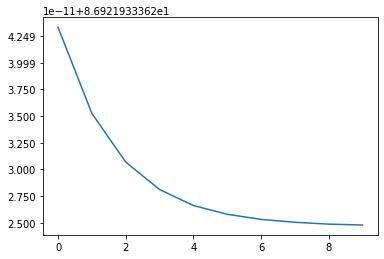

In [862]:
plt.plot(res)


In [863]:
l = loss_getter(5, 5, jnp.diag(D_diag), sig)
g_l = grad(loss_getter(5, 5, jnp.diag(D_diag), sig))
h_l = jacfwd(g_l)

g_l(opt_S.T.flatten())

DeviceArray([ 9.61854463e-09,  1.48309809e-10,  3.73404418e-10,
              2.47474929e-10,  5.09920994e-10,  9.50887946e-09,
              3.93225008e-10, -1.00793152e-10, -4.60879335e-10,
             -1.12548548e-09,  9.48215706e-09, -4.84803309e-11,
              2.01278993e-11,  9.85025395e-11, -1.09736220e-10,
              9.46668771e-09, -1.53697499e-10,  7.73194841e-11,
             -5.19634114e-10,  1.93598026e-10,  9.50466600e-09,
             -5.11113374e-11,  1.87291960e-09, -6.94406310e-10,
             -1.53002588e-09], dtype=float64)

In [864]:
jnp.linalg.eigh(h_l(opt_S.T.flatten()))

(DeviceArray([-4.06875622e-10,  2.68286514e-09,  3.20002756e-03,
               7.25325924e-03,  8.60100791e-03,  9.63505220e-03,
               1.05055885e-02,  1.67715728e+00,  9.28607864e+00,
               1.40190945e+01,  2.52580120e+01,  1.69779818e+02,
               3.44976438e+02,  4.20748219e+02,  4.84691221e+02,
               5.78895234e+02,  6.60389500e+02,  9.67603140e+02,
               1.00732566e+03,  1.26190420e+03,  1.70135414e+03,
               4.37820017e+07,  5.66077168e+07,  7.38940611e+07,
               8.73143488e+07], dtype=float64),
 DeviceArray([[ 5.23463080e-08,  4.68296487e-08,  4.47211557e-01,
               -3.86035649e-01,  5.83547541e-01, -2.87806019e-01,
                4.77002461e-01, -7.77331713e-03,  2.87872750e-03,
               -3.62663890e-03,  1.97888702e-03, -5.76481648e-04,
                6.34645525e-04, -1.94882038e-04,  2.13104244e-04,
               -3.67804171e-04,  3.10544976e-04, -1.41371164e-04,
                4.64959705e-05,  1.1

In [724]:
_, SIG, V = jnp.linalg.svd(opt_S)

In [196]:
V**2

DeviceArray([[2.00000000e-01, 2.00000000e-01, 2.00000000e-01,
              2.00000000e-01, 2.00000000e-01],
             [8.62957698e-04, 2.85651167e-01, 2.00445958e-01,
              2.83489751e-01, 2.29550167e-01],
             [4.88320787e-01, 1.59221482e-02, 2.63074223e-01,
              2.16876373e-02, 2.10995205e-01],
             [3.10581652e-01, 2.83587203e-01, 6.06286388e-02,
              2.79031928e-01, 6.61705783e-02],
             [2.34602463e-04, 2.14839482e-01, 2.75851180e-01,
              2.15790684e-01, 2.93284050e-01]], dtype=float64)

In [203]:
V.T**2 @ (SIG**2 * D_diag)

DeviceArray([27.85550812, 27.85550799, 27.85550799, 27.85550798,
             27.85550798], dtype=float64)

In [209]:
(V.T**2)[0]

DeviceArray([2.00000000e-01, 8.62957698e-04, 4.88320787e-01,
             3.10581652e-01, 2.34602463e-04], dtype=float64)

In [208]:
(V.T**2)[1]

DeviceArray([0.2       , 0.28565117, 0.01592215, 0.2835872 , 0.21483948],            dtype=float64)

In [210]:
(V.T**2)[2]

DeviceArray([0.2       , 0.20044596, 0.26307422, 0.06062864, 0.27585118],            dtype=float64)

In [211]:
 (SIG**2 * D_diag)

DeviceArray([70.06956453, 11.38184803, 15.93932236, 19.45706893,
             22.4297362 ], dtype=float64)

In [333]:
_, SIG, V = jnp.linalg.svd(opt_S)

In [334]:
D_diag = jnp.l(1, 1e2, 5)


V.T**2 @ (SIG**2 * D_diag)

DeviceArray([33.90075415, 32.68117736, 34.1853202 , 34.1853202 ,
             33.90075415], dtype=float64)

In [335]:
V**2

DeviceArray([[2.03107769e-01, 1.97428363e-01, 1.98178050e-01,
              1.98178050e-01, 2.03107769e-01],
             [1.69203849e-02, 4.97947021e-01, 2.34106105e-01,
              2.34106105e-01, 1.69203849e-02],
             [5.00000000e-01, 5.80550481e-24, 8.27660310e-25,
              8.33123483e-25, 5.00000000e-01],
             [1.72551904e-27, 3.16507320e-27, 5.00000000e-01,
              5.00000000e-01, 1.47332791e-27],
             [2.79971846e-01, 3.04624617e-01, 6.77158454e-02,
              6.77158454e-02, 2.79971846e-01]], dtype=float64)

In [336]:
jnp.linalg.det(V)

DeviceArray(-1., dtype=float64)

In [868]:

def generate_regular_simplex(dim):
    res = []
    I = np.eye(dim)
    for i in range(dim):
        res.append(jnp.sqrt(1 + 1/dim) * I[i] - 1/pow(dim, 3/2) *(np.sqrt(dim + 1) + 1) * np.ones(dim))
        
    res.append(1/np.sqrt(dim) * np.ones(dim))
    
    return jnp.array(res).T

def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

    return helper



def convert_to_U(W, to_insert):
    dim = W.shape[0] + 1
    V = generate_regular_simplex(dim - 1)
    tmp_U = (jnp.sqrt((dim - 1)/dim) * W @ V)
    U = jnp.insert(tmp_U, to_insert, jnp.ones(shape=(1, dim))/jnp.sqrt(dim), axis=0)
    return U

def construct_c(sing_vals, D):
    return sing_vals**2 * jnp.diag(D)

def orthog_linesearch(l, c1, c2):

    def helper(X, search_direction, A):
        f0 = l(X)
        g_tau_0 = -1/2 * jnp.linalg.norm(A, "fro")**2
        
        def armijo_rule(alpha):
            return (l(search_direction(alpha)) > f0 + c1*alpha*g_tau_0) # and alpha > 0.001
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        max_calls = 100
        while armijo_rule(alpha) and max_calls > 0:
            alpha = armijo_update(alpha)
            max_calls -= 1

        return alpha

    return helper


def optimize_W(c, num_iter, x_init=None):
    """Constraint is U.c = \bar{c} 1 and U.U^T = I"""
    
    dim = len(c)
    
    V = generate_regular_simplex(dim)
    
    # init X
    if x_init is None:
        X = jnp.eye(dim)
    else:
        X = x_init
    I = jnp.eye(dim)
    
    
    def l(U):
        U_matrix = U.reshape(dim, dim)
        return jnp.linalg.norm(jnp.diag(V.T @ U_matrix.T @ jnp.diag(c) @ U_matrix @ V) - jnp.ones(dim + 1) * jnp.mean(c)) 
    
    
    g_l = grad(l)
    linesearch = orthog_linesearch(l, c1=0.1, c2=0.9)


    eps = 1e-4
    l_eps = 1e-2
    
    l_hist = []
    for _ in range(num_iter):
        num_iter -= 1
        
        G = g_l(X.flatten()).reshape(dim, dim)
        l_hist.append(l(X))
        
        if l_hist[-1] < l_eps:
            break

        if jnp.linalg.norm(G) < eps:
            break
        
        A = G @ X.T - X @ G.T
                
        Y = lambda tau: jnp.linalg.inv(I + tau/2 * A) @ (I - tau/2 * A) @ X
        
        alpha = linesearch(X, Y, A)

        
        X = Y(alpha)
    # plt.plot(l_hist)
    # plt.show()
    print(l_hist[-1])
    return X, l_hist


def create_S(H, sig, num_iter=10, x_init=None):
    dim = H.shape[0] 


    sing_vals = get_full_sing_vals(D, dim, sig)
    c = construct_c(sing_vals, D)
    min_D = jnp.diag(D).argmin()
    W, l_hist = optimize_W(np.delete(c, min_D), num_iter, x_init=x_init) 
    U = convert_to_U(W, min_D)


In [882]:
min_D = D_diag.argmin()


c = D_diag * lambda_coeff_zero(D_diag, sig)
num_iter = 20

W, l_hist = optimize_W(np.delete(c, min_D), num_iter, x_init=None) 

3.5999382450904065


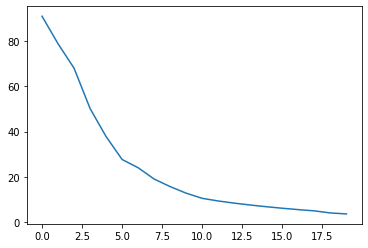

In [883]:
plt.plot(l_hist)

In [345]:
convert_to_U(W, min_D)



DeviceArray([[ 0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ,
               0.4472136 ],
             [ 0.45325026, -0.36939767, -0.11589638, -0.55150087,
               0.58354467],
             [-0.53255701,  0.61633658, -0.12679408, -0.37818662,
               0.42120113],
             [-0.26450555, -0.20711341,  0.87709287, -0.33623676,
              -0.06923716],
             [-0.49090126, -0.49069198, -0.03463205,  0.48965959,
               0.52656571]], dtype=float64)

In [346]:
convert_to_U(W, min_D)**2

DeviceArray([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
             [0.2054358 , 0.13645464, 0.01343197, 0.30415321, 0.34052438],
             [0.28361697, 0.37987078, 0.01607674, 0.14302512, 0.17741039],
             [0.06996318, 0.04289596, 0.76929191, 0.11305516, 0.00479378],
             [0.24098405, 0.24077862, 0.00119938, 0.23976651, 0.27727144]],            dtype=float64)

In [347]:
V**2

DeviceArray([[2.03107769e-01, 1.97428363e-01, 1.98178050e-01,
              1.98178050e-01, 2.03107769e-01],
             [1.69203849e-02, 4.97947021e-01, 2.34106105e-01,
              2.34106105e-01, 1.69203849e-02],
             [5.00000000e-01, 5.80550481e-24, 8.27660310e-25,
              8.33123483e-25, 5.00000000e-01],
             [1.72551904e-27, 3.16507320e-27, 5.00000000e-01,
              5.00000000e-01, 1.47332791e-27],
             [2.79971846e-01, 3.04624617e-01, 6.77158454e-02,
              6.77158454e-02, 2.79971846e-01]], dtype=float64)

In [881]:
convert_to_U(W, min_D).T**2 @ (l_curr * D_diag)

DeviceArray([1464.1212047 , 1447.96052931, 1462.53179219, 1468.72421762,
             1494.97148799], dtype=float64)

In [349]:
V.T**2 @ (SIG * D_diag)

DeviceArray([18.83362301, 17.52869294, 15.54872977, 15.54872977,
             18.83362301], dtype=float64)

In [877]:
lambda_coeff_zero(D_diag, sig)

DeviceArray([2.17307594e+04, 1.41419684e-01, 9.99998177e-02,
             8.16497814e-02, 7.07109027e-02], dtype=float64)

In [879]:
l_curr = lambda_coeff_zero(D_diag, sig)**0.5
pred_S = jnp.diag(l_curr) @ convert_to_U(W, min_D)

In [880]:
l(pred_S.T.flatten())

DeviceArray(97.63444412, dtype=float64)

In [874]:
jnp.linalg.svd(pred_S)

(DeviceArray([[-1.00000000e+00, -3.38813179e-21,  8.47032947e-22,
               -2.96461532e-21,  4.23516474e-21],
              [-1.69406589e-21, -1.00000000e+00, -2.62012095e-17,
                1.90143584e-16, -4.39639029e-16],
              [ 1.69406589e-21,  1.95843395e-16, -1.00000000e+00,
                6.65619383e-16,  2.80920175e-16],
              [-4.23516474e-22,  1.42923323e-16,  8.05426125e-16,
                1.00000000e+00, -4.50051790e-15],
              [-1.27054942e-21,  3.93028239e-16,  1.14386722e-16,
               -4.37432740e-15, -1.00000000e+00]], dtype=float64),
 DeviceArray([2.17307594e+04, 1.41419684e-01, 9.99998177e-02,
              8.16497814e-02, 7.07109027e-02], dtype=float64),
 DeviceArray([[-0.4472136 , -0.4472136 , -0.4472136 , -0.4472136 ,
               -0.4472136 ],
              [-0.42816052,  0.03693098,  0.45516764,  0.51852756,
               -0.58246567],
              [ 0.54497768, -0.78364584,  0.17724064,  0.1974435 ,
               -0.1

In [875]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-1.00000000e+00, -3.39572120e-16,  7.19910243e-17,
                1.25333771e-16, -1.64798730e-16],
              [ 3.42174206e-16, -1.00000000e+00, -9.74336688e-14,
                5.49295954e-15, -7.92018200e-15],
              [-7.15573434e-17,  9.71879132e-14, -1.00000000e+00,
                2.38411657e-14, -9.69862974e-15],
              [ 1.26201133e-16,  5.66404410e-15,  2.36202210e-14,
                1.00000000e+00, -4.06530091e-13],
              [ 1.65666092e-16,  8.06762799e-15,  9.25963882e-15,
               -4.06417824e-13, -1.00000000e+00]], dtype=float64),
 DeviceArray([147.41357267,   0.37605809,   0.31622748,   0.28574426,
                0.26591522], dtype=float64),
 DeviceArray([[-0.4472136 , -0.4472136 , -0.4472136 , -0.4472136 ,
               -0.4472136 ],
              [-0.38602862, -0.58414521,  0.53546222,  0.47088035,
               -0.03616874],
              [-0.58375551,  0.09003687, -0.14334048, -0.14388487,
                0.78094399],


In [354]:
l(opt_S.T.flatten())

DeviceArray(27.80474141, dtype=float64)

In [866]:
l(create_approx_S_multi(jnp.diag(D_diag), sig, None, None).T.flatten())



DeviceArray(3617.01002089, dtype=float64)

In [359]:
jnp.linalg.svd(create_approx_S_multi(jnp.diag(D_diag), sig, None, None))

(DeviceArray([[-1.00000000e+00, -4.15654436e-17,  5.55111512e-17,
               -4.16333634e-17, -4.16333634e-17],
              [ 0.00000000e+00,  1.00000000e+00, -1.66533454e-15,
               -3.55271368e-15,  1.72084569e-15],
              [-2.77555756e-17,  2.10678390e-15,  1.00000000e+00,
               -4.76181594e-16,  3.44342610e-16],
              [-1.38777878e-17, -3.66571559e-15, -8.63024929e-16,
               -1.00000000e+00, -2.35922393e-16],
              [-2.77555756e-17,  1.71936119e-15,  3.98986399e-17,
                9.58434720e-17, -1.00000000e+00]], dtype=float64),
 DeviceArray([6.23450918, 0.94574161, 0.79796106, 0.59838638, 0.44872648],            dtype=float64),
 DeviceArray([[-5.00000000e-01,  0.00000000e+00, -5.00000000e-01,
               -5.00000000e-01, -5.00000000e-01],
              [ 0.00000000e+00,  1.00000000e+00, -2.44249065e-15,
                1.77635684e-15,  9.99200722e-16],
              [ 5.00000000e-01, -1.55431223e-15, -5.00000000e-01,
   

In [878]:
lall = lambda_coeff_zero(D_diag, sig)
print(lall)
fall = lmbda_loss(lall, D_diag, sig, np.argmin(D_diag))
print("fun all", fall)



[2.17307594e+04 1.41419684e-01 9.99998177e-02 8.16497814e-02
 7.07109027e-02]
fun all 86.92193336252464


In [865]:
res[-1]

DeviceArray(86.92193336, dtype=float64)

In [ ]:
# Only use for trying different choices for the pow_index_sets. 
def get_S_pow_index_sets_rand(D_diag, jrandom_key=None):
    """Returns a set of sets. Each set with the indecies of H to use."""
    jrandom_key = jrandom.PRNGKey(np.random.randint(0, 100))
    dim = len(D_diag)
    curr_n = 0
    res = []
    indecies = jnp.array(range(dim))
    indecies = jrandom.permutation(jrandom_key, indecies, independent=True)
    curr_i = 0
    while dim > 0:
        if dim % 2 == 1:
            dim = (dim - 1)/2
            res.append(jnp.sort(indecies[curr_i:curr_i + 2**curr_n]))
            curr_i += 2**curr_n
            curr_n += 1
        else:
            curr_n += 1
            dim = dim/2
            res.append(None)
    return res

def old_get_S_pow_index_sets(D_diag,):
    """Returns a set of sets. Each set with the indecies of H to use."""
    dim = len(D_diag)
    curr_n = int(math.log2(dim))
    res = []
    curr_start = 0
    curr_end = dim
    while curr_n >= 0:

        if dim >= 2**curr_n:
            dim = dim - 2**curr_n
            next_start = int(curr_start + 2**(curr_n-1))
            next_end = int(curr_end - 2**(curr_n-1)) # will round down when curr_n == 0 while the one above will not round up. so we are good. 
            res.append(jnp.array(list(range(curr_start, next_start)) + list(range(next_end, curr_end))))
            curr_start = next_start
            curr_end = next_end
            curr_n -= 1
        else:
            curr_n -= 1
            res.append(None)
    return res[::-1]

(array([1., 2., 2., 2., 6., 3., 4.]),
 array([50.        , 54.71428571, 59.42857143, 64.14285714, 68.85714286,
        73.57142857, 78.28571429, 83.        ]),
 <BarContainer object of 7 artists>)

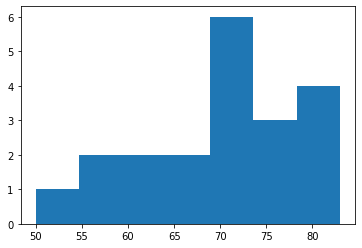

In [9]:

grd = [71, 79, 72, 77, 60, 72, 64, 70, 80, 73, 66, 83, 69, 79, 58, 77, 58, 77, 50, 65]
plt.hist(grd, bins=7)



In [15]:
res = np.array([[0.00311252, 0.000101309],
[0.00347472, 0.000236526],
[0.0105507, 0.000229789],
[-5.52553e-05, 0.000151498],
[0.0024493, 0.000115099],
[-0.00344531, 0.000123262],
[0.00811308, 0.00013057],
[0.0045862, 7.32582e-05],
[-0.000467935, 0.000741309],
[0.00645996, 0.000477385],
[0.00360198, 0.000157982],
[0.00478154, 0.000204837],
[0.00276193, 7.46504e-05],
[-0.00407409, 0.000287393],
[-0.00186455, 0.0002852],
[-0.00546151, 0.000676818],
[-0.000369483, 0.000635041],
[-0.00474919, 0.000319618],
[-0.00325508, 0.00074294],
[0.0107296, 0.00214335],
[-0.0156598, 0.000680763],
[0.00423428, 0.000554002],
[0.0100334, 0.0002813],
[0.00449337, 0.000217061],
[-0.00253388, 0.000121177],
[-0.00189742, 0.00023984],
[0.0037909, 0.000255839],
[0.00385595, 0.000139007],
[0.00118621, 0.00019287],
[0.00359684, 0.000115248],
[-0.000671179, 0.000186274],
[0.00383318, 0.000261197],
[-0.00405596, 0.000141916],
[0.00194106, 0.000151036],
[0.00504568, 0.000123505],
[0.003647, 0.000128514],
[-0.0018917, 0.000111955],
[0.00507159, 0.000106074],
[0.000589177, 0.000115222],
[-0.00051055, 0.000289711],
[0.00175062, 0.000139805],
[-0.00401138, 0.000194803],
[0.00404799, 0.000184815],
[-0.00179794, 0.000124969],
[-0.00501302, 0.000222046],
[0.00640203, 0.000963562],
[0.0037365, 0.00022995],
[0.000398045, 0.000329082],
[-0.00462455, 0.00152763],
])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 3., 2., 1., 2., 1., 0., 4., 0., 4., 1., 2., 1., 1., 1.,
        2., 1., 8., 2., 3., 2., 0., 2., 0., 0., 0., 1., 0., 0., 1., 2.]),
 array([-0.0156598 , -0.01513201, -0.01460422, -0.01407644, -0.01354865,
        -0.01302086, -0.01249307, -0.01196528, -0.0114375 , -0.01090971,
        -0.01038192, -0.00985413, -0.00932634, -0.00879856, -0.00827077,
        -0.00774298, -0.00721519, -0.0066874 , -0.00615962, -0.00563183,
        -0.00510404, -0.00457625, -0.00404846, -0.00352068, -0.00299289,
        -0.0024651 , -0.00193731, -0.00140952, -0.00088174, -0.00035395,
         0.00017384,  0.00070163,  0.00122942,  0.0017572 ,  0.00228499,
         0.00281278,  0.00334057,  0.00386836,  0.00439614,  0.00492393,
         0.00545172,  0.00597951,  0.0065073 ,  0.00703508,  0.00756287,
         0.00809066,  0.00861845,  0.00914624,  0.00967402,  0.01020181,
         0.0107296 ]),
 <BarContainer object

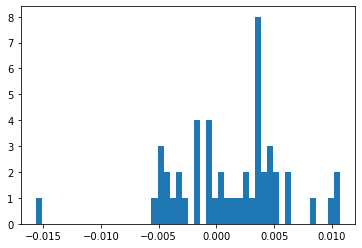

In [19]:
np.mean(res[:, 0])

plt.hist(res[:, 0], bins=50)